In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from config import *
from encoder import *
from data import *
from clip import *
from clip3d import *
from eval import *
from augmentor import *
from describer import *
from masker import *
print("using device: ", device)
random_state = 333
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



Random seed set to 333
using device:  cpu


In [3]:
# ---- update configs ----
overwrite = True
model_name = 'test3d_unmask'
text_config['cl']['die7d'] = True # udpate text_config here if needed
model_name = model_name + "___" + "_".join(get_true_components(text_config))
txt_ls = ['will die', 'will survive']

update_config(
    model_name = model_name,
    ts_aug = True,
    ts_subseq = False,
    balance = True,
    block_target = True,
    txt_ls = txt_ls,
    batch_size = 2048, # larger batch 
    patience = 50,
    num_saves = 20,
    num_epochs = 1,
    text_config = text_config
)
config_dict = get_config_dict()
config_dict

{'device': 'cpu',
 'batch_size': 2048,
 'text_encoder_name': 'sentence-transformers/all-mpnet-base-v2',
 'ts_encoder_name': 'hr_vae_linear_medium',
 'ts_aug': True,
 'ts_subseq': False,
 'ts_normalize': False,
 'ts_encode': False,
 'block_target': True,
 'balance': True,
 'model_name': 'test3d_unmask___die7d_ga_bwt_sumb_simple_succ_inc_histogram',
 'embedded_dim': 128,
 'init_lr': 0.0001,
 'patience': 50,
 'num_saves': 20,
 'num_epochs': 1,
 'loss_type': 'block_diagonal',
 'txt_ls': ['will die', 'will survive'],
 'text_config': {'cl': {'die7d': True, 'fio2': False},
  'demo': {'ga_bwt': True, 'gre': False, 'apgar_mage': False},
  'ts': {'sumb': True,
   'sumd': False,
   'simple': True,
   'full': False,
   'event1': False,
   'succ_inc': True,
   'histogram': True},
  'split': False}}

In [4]:
# ---------------- define classification outcome and its levels ----------------
y_col = 'cl_event'
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']


# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org[y_col], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.6s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    5.2s
[Parallel(n_jobs=9)]: Done 63060 tasks      | elapsed:   14.2s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   14.5s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.    Moderate variability.  Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.5s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    8.8s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    8.9s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.    High variability.  Low amount of consecutive increases. 


In [5]:
# # Get time series columns
# ts_cols = [str(i) for i in range(1, 301)]
# # Combine with other columns
# cols_to_save = ['VitalID', 'VitalTime', 'cl_event'] + ts_cols

# # Save to CSV
# df_train[cols_to_save].to_csv("./tmp/df_train.csv.zip", index=False)
# df_test[cols_to_save].to_csv("./tmp/df_test.csv.zip", index=False)

In [6]:
# ---- downsample negative class(es) ----
neg_sample_size = 1000
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth'#,
                                    # max_size=max_size, 
                                    # K=10 
                                    )
    df_test['augid'] = 0




# ---- created masked subsequences of each time series ----
if config_dict['ts_subseq']:
    def subseq_raw_df(df, n=1): 
        df.index = df.index.astype(str) # index should be str for both df and combined_df, aug or not
        ts_df = df[[str(i) for i in range(1, 301)]]
        combined_df = get_subseq_parallel(ts_df, n=n, 
                                        min_length_ratio=1/6, 
                                        max_length_ratio=2/3, 
                                        step_size_ratio=1/30, random_state=333)
        merge_cols = [col for col in df.columns if col not in combined_df.columns] # Get columns to merge (columns in df_train that aren't in combined_df)
        merge_df = df[merge_cols].copy()# Create a temporary DataFrame with just the columns we want to merge
        combined_df = combined_df.join(merge_df, how='left') # Merge using index
        combined_df = text_gen_input_column(combined_df, config_dict['text_config'])
        df['subid'] = 0
        combined_df = combined_df[df.columns]
        df_final = pd.concat([df, combined_df], axis=0)
        # should be same shape as df_train and df_test (before training)
        return df_final

    df_train = subseq_raw_df(df_train)
    df_test = subseq_raw_df(df_test)

    # Fill with 0 and create attention masks
    df_train.loc[:, '1':'300'] = df_train.loc[:, '1':'300'].fillna(-1)
    # mask_train = ~df_train.loc[:, '1':'300'].isna().astype(float)
    df_test.loc[:, '1':'300'] = df_test.loc[:, '1':'300'].fillna(-1)
    # mask_test = ~df_test.loc[:, '1':'300'].isna().astype(float)

print(df_train[y_col].value_counts())
print(df_test[y_col].value_counts())

# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    if 'subid' in df_train.columns:
        df_train['label'] = df_train['rowid'].astype(int)*100 + df_train['subid'].astype(int)
        df_test['label'] = df_test['rowid'].astype(int)*100 + df_test['subid'].astype(int)
    else:
        df_train['label'] = df_train['rowid'].astype(int)
        df_test['label'] = df_test['rowid'].astype(int)


Original class distribution:
Class This infant will die in 7 days. : 384
Class This infant will survive. : 1000

Target size per class: 1000
Total cores available: 12
Using 9 cores for parallel processing


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.


Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333


[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    2.1s
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by

Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333


[Parallel(n_jobs=9)]: Done 384 out of 384 | elapsed:    9.4s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=9)]: Done 751 out of 768 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=9)]: Done 768 out of 768 | elapsed:    0.7s finished


This infant will die in 7 days.  This infant has gestational age 24 weeks. Birth weight is 400 grams.    Moderate variability.  Low amount of consecutive increases. 
Augmented 1536 rows

Final class distribution:
Class This infant will die in 7 days. : 1000
Class This infant will survive. : 1000
cl_event
This infant will survive.           1000
This infant will die in 7 days.     1000
Name: count, dtype: int64
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


In [7]:

# ---- ready dataloaders ---- 
text_col_ls = ['demo', y_col, 'ts_description']
ts_f_train, tx_f_train_ls, labels_train = get_features3d(df_train,
                                                         config_dict['ts_encoder_name'], 
                                                         config_dict['text_encoder_name'], 
                                                         config_dict['ts_normalize'],
                                                         config_dict['ts_encode'],
                                                         text_col_ls = text_col_ls)
train_dataloader = CLIP3DDataset(ts_f_train, tx_f_train_ls, labels_train).dataloader(batch_size=config_dict['batch_size'])
ts_f_test, tx_f_test_ls, labels_test = get_features3d(df_test, 
                                                      config_dict['ts_encoder_name'], 
                                                      config_dict['text_encoder_name'], 
                                                      config_dict['ts_normalize'],
                                                      config_dict['ts_encode'],
                                                      text_col_ls = text_col_ls)
test_dataloader = CLIP3DDataset(ts_f_test, tx_f_test_ls, labels_test).dataloader(batch_size=config_dict['batch_size'])


# ---- ready eval inputs ----
# substitute y_col with text1 and text2 in text_col_ls
y_pred_cols_ls = [[x if x != y_col else 'text1' for x in text_col_ls], 
                  [x if x != y_col else 'text2' for x in text_col_ls]]

# create a onehot indicator of true text of first level of outcome, "this infant will die in 7 days"
df_train['true1'] = df_train[y_col].apply(lambda x: 1 if x == txt_ls_org[0] else 0)
df_train['true2'] = df_train[y_col].apply(lambda x: 1 if x == txt_ls_org[1] else 0)
df_train['text1'] = config_dict['txt_ls'][0]
df_train['text2'] = config_dict['txt_ls'][1]
evalinputs_train = EvalInputs(df_train, 
                              config_dict['ts_encoder_name'],
                              config_dict['text_encoder_name'], 
                              config_dict['ts_normalize'], 
                              config_dict['ts_encode'],
                              clip_type="3d",
                              y_pred_cols_ls=y_pred_cols_ls)

df_test['true1'] = df_test[y_col].apply(lambda x: 1 if x == txt_ls_org[0] else 0)
df_test['true2'] = df_test[y_col].apply(lambda x: 1 if x == txt_ls_org[1] else 0)
df_test['text1'] = config_dict['txt_ls'][0]
df_test['text2'] = config_dict['txt_ls'][1]
evalinputs_test = EvalInputs(df_test, 
                              config_dict['ts_encoder_name'],
                              config_dict['text_encoder_name'], 
                              config_dict['ts_normalize'], 
                              config_dict['ts_encode'],
                              clip_type="3d",
                              y_pred_cols_ls=y_pred_cols_ls)


print(df_train[y_col].value_counts())
print(df_test[y_col].value_counts())

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will survive.           1000
This infant will die in 7 days.     1000
Name: count, dtype: int64
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


# Main Usage

In [8]:
# ---- ready data storage ---- 
import shutil
if overwrite:
    # remove the subfolder './results/'+model_name
    if os.path.exists('./results/'+model_name):
        shutil.rmtree('./results/'+model_name)
    overwrite = False # reset overwrite to False

if not os.path.exists('./results/'+model_name):
    os.makedirs('./results/'+model_name)
model_path = './results/'+model_name+'/model.pth' 
eval_path = './results/'+model_name+'/evals.pth'
config_path = './results/'+model_name+'/config.pth'
if not os.path.exists(config_path):
    torch.save(config_dict, config_path)

# ---- ready model ----
# for the sake of dimension
ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.loc[:1,:], 
                                                   config_dict['ts_encoder_name'], 
                                                   config_dict['text_encoder_name'], 
                                                   config_dict['ts_normalize'],
                                                   config_dict['ts_encode'],
                                                   text_col_ls = text_col_ls)
# lstm_encoder = LSTMEncoder(ts_dim=300, output_dim=128, num_layers=4, hidden_dim=256, dropout=0.1)
lstm_encoder = MultiLSTMEncoder(
    ts_dim=ts_f_dim.shape[1], 
    output_dim=128,
    hidden_dims=[256, 256, 256, 128, 128, 128],  # LSTMs with different sizes
    num_layers=2,
    mask=-1
)
model = CLIP3DModel(
            ts_dim=ts_f_dim.shape[1],
            text_dim=tx_f_dim_ls[0].shape[1],
            n_text=len(tx_f_dim_ls),
            output_dim=config_dict['embedded_dim'],
            ts_encoder=lstm_encoder
        )
optimizer = torch.optim.AdamW(model.parameters(), lr=config_dict['init_lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=config_dict['patience'],          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)
train_eval_metrics_list = []
test_eval_metrics_list = []
train_losses = []
test_losses = []

Layer (type:depth-idx)                                                 Param #
CLIP3DModel                                                            1
├─MultiLSTMEncoder: 1-1                                                --
│    └─ModuleList: 2-1                                                 --
│    │    └─LSTM: 3-1                                                  1,097,728
│    │    └─LSTM: 3-2                                                  1,097,728
│    │    └─LSTM: 3-3                                                  1,097,728
│    │    └─LSTM: 3-4                                                  352,256
│    │    └─LSTM: 3-5                                                  352,256
│    │    └─LSTM: 3-6                                                  352,256
│    └─Sequential: 2-2                                                 --
│    │    └─Linear: 3-7                                                664,128
│    │    └─BatchNorm1d: 3-8                                       

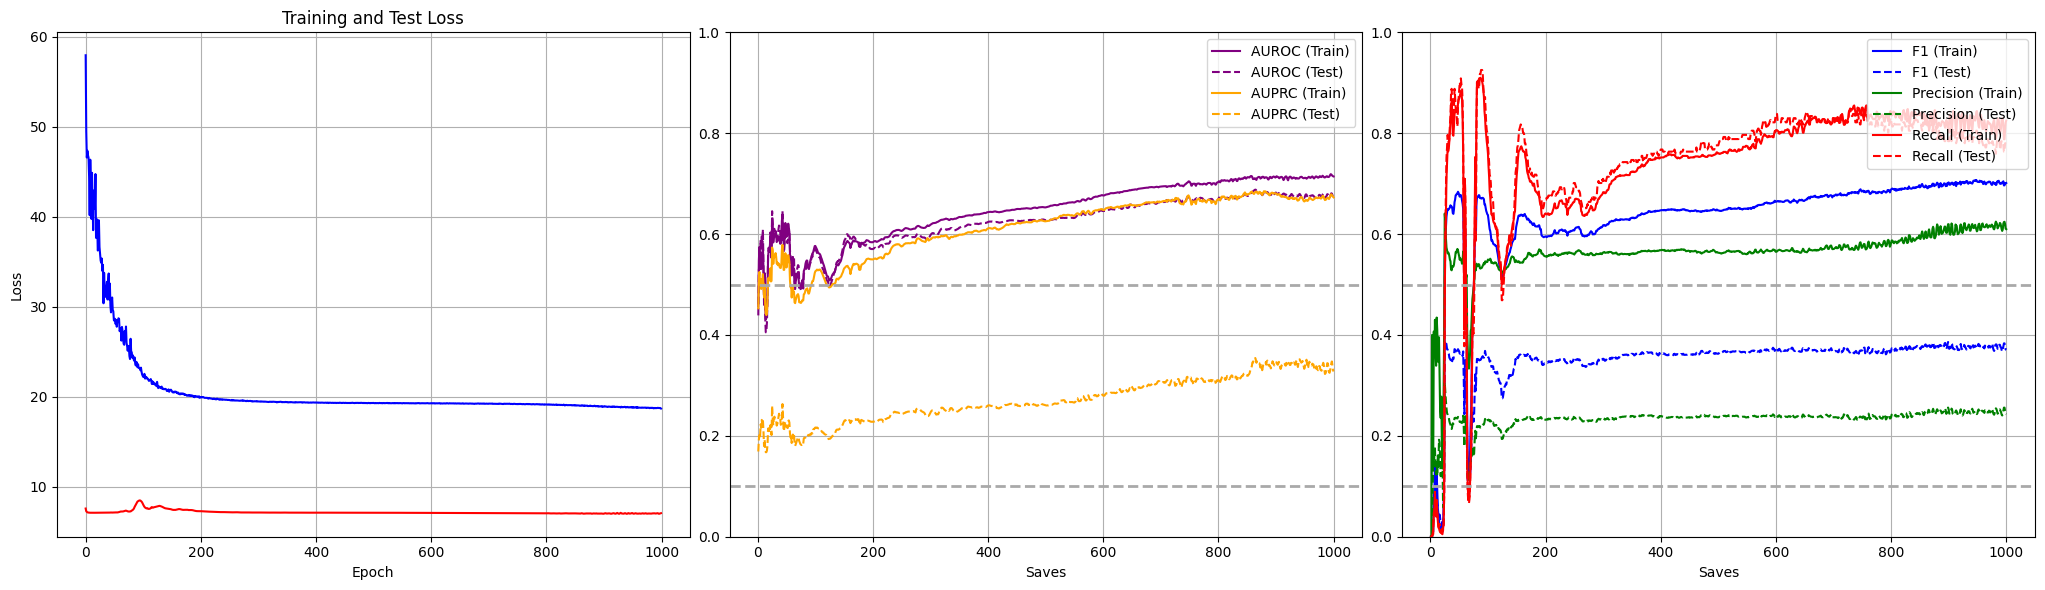

In [12]:
overwrite = False
if overwrite or not os.path.exists(model_path):
    
    for i in range(1000): 
        print(i)
        train_losses_tmp, test_losses_tmp = train_clip(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                config_dict['num_epochs'], 
                                                device,
                                                config_dict['loss_type'])
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        train_eval_metrics = eval_clip3d(model, evalinputs_train)
        test_eval_metrics = eval_clip3d(model, evalinputs_test)
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_path)
        # if i % 10 == 0: # every 10 saves, evaluate the model
        eval_dict = torch.load(eval_path)
        eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)
    
else:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    eval_dict = torch.load(eval_path)
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=False)

# dignostic plots

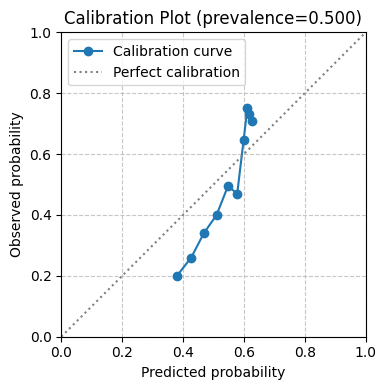

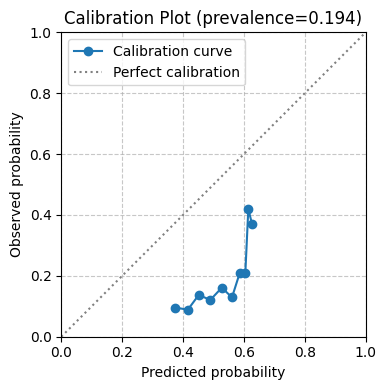

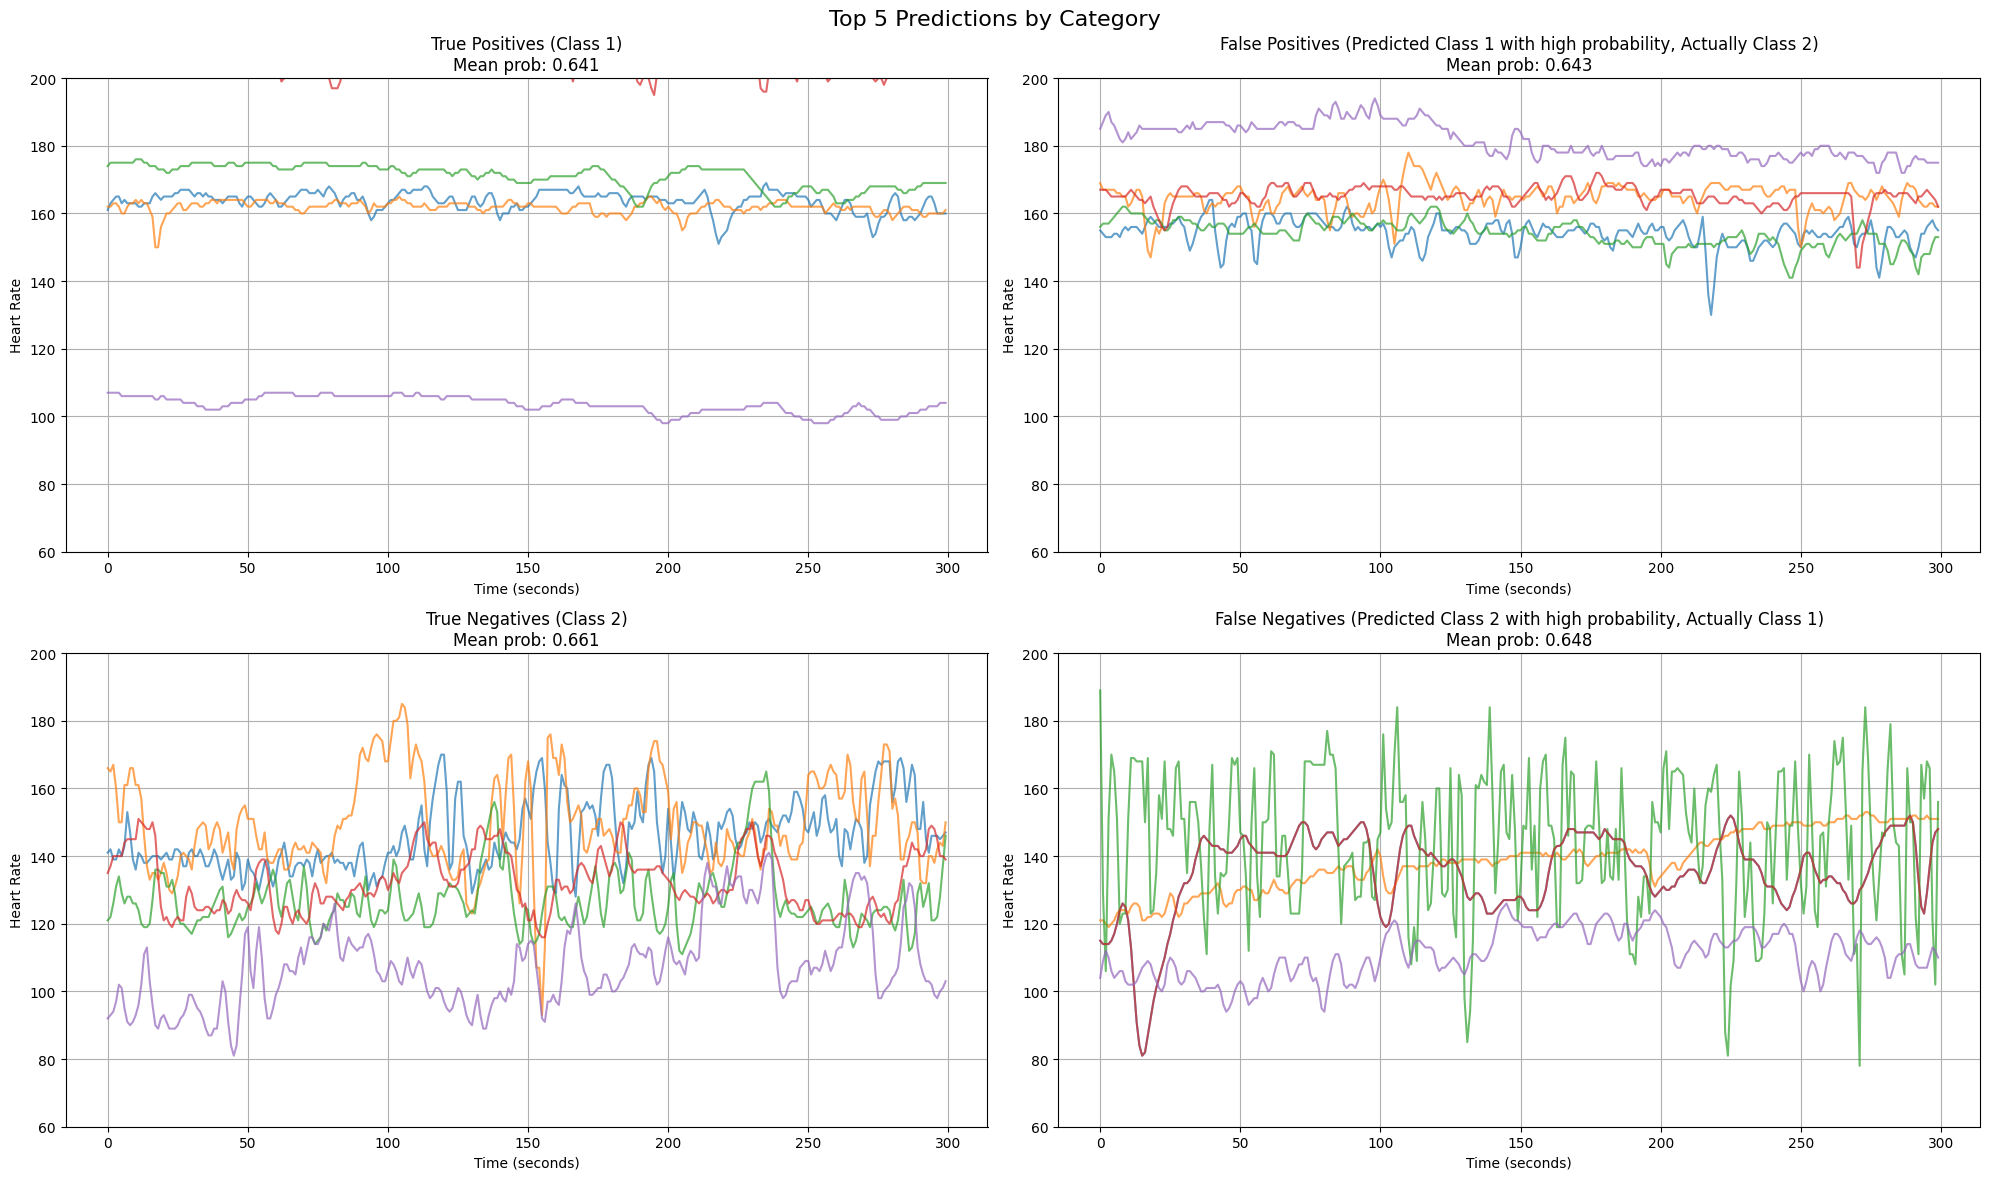

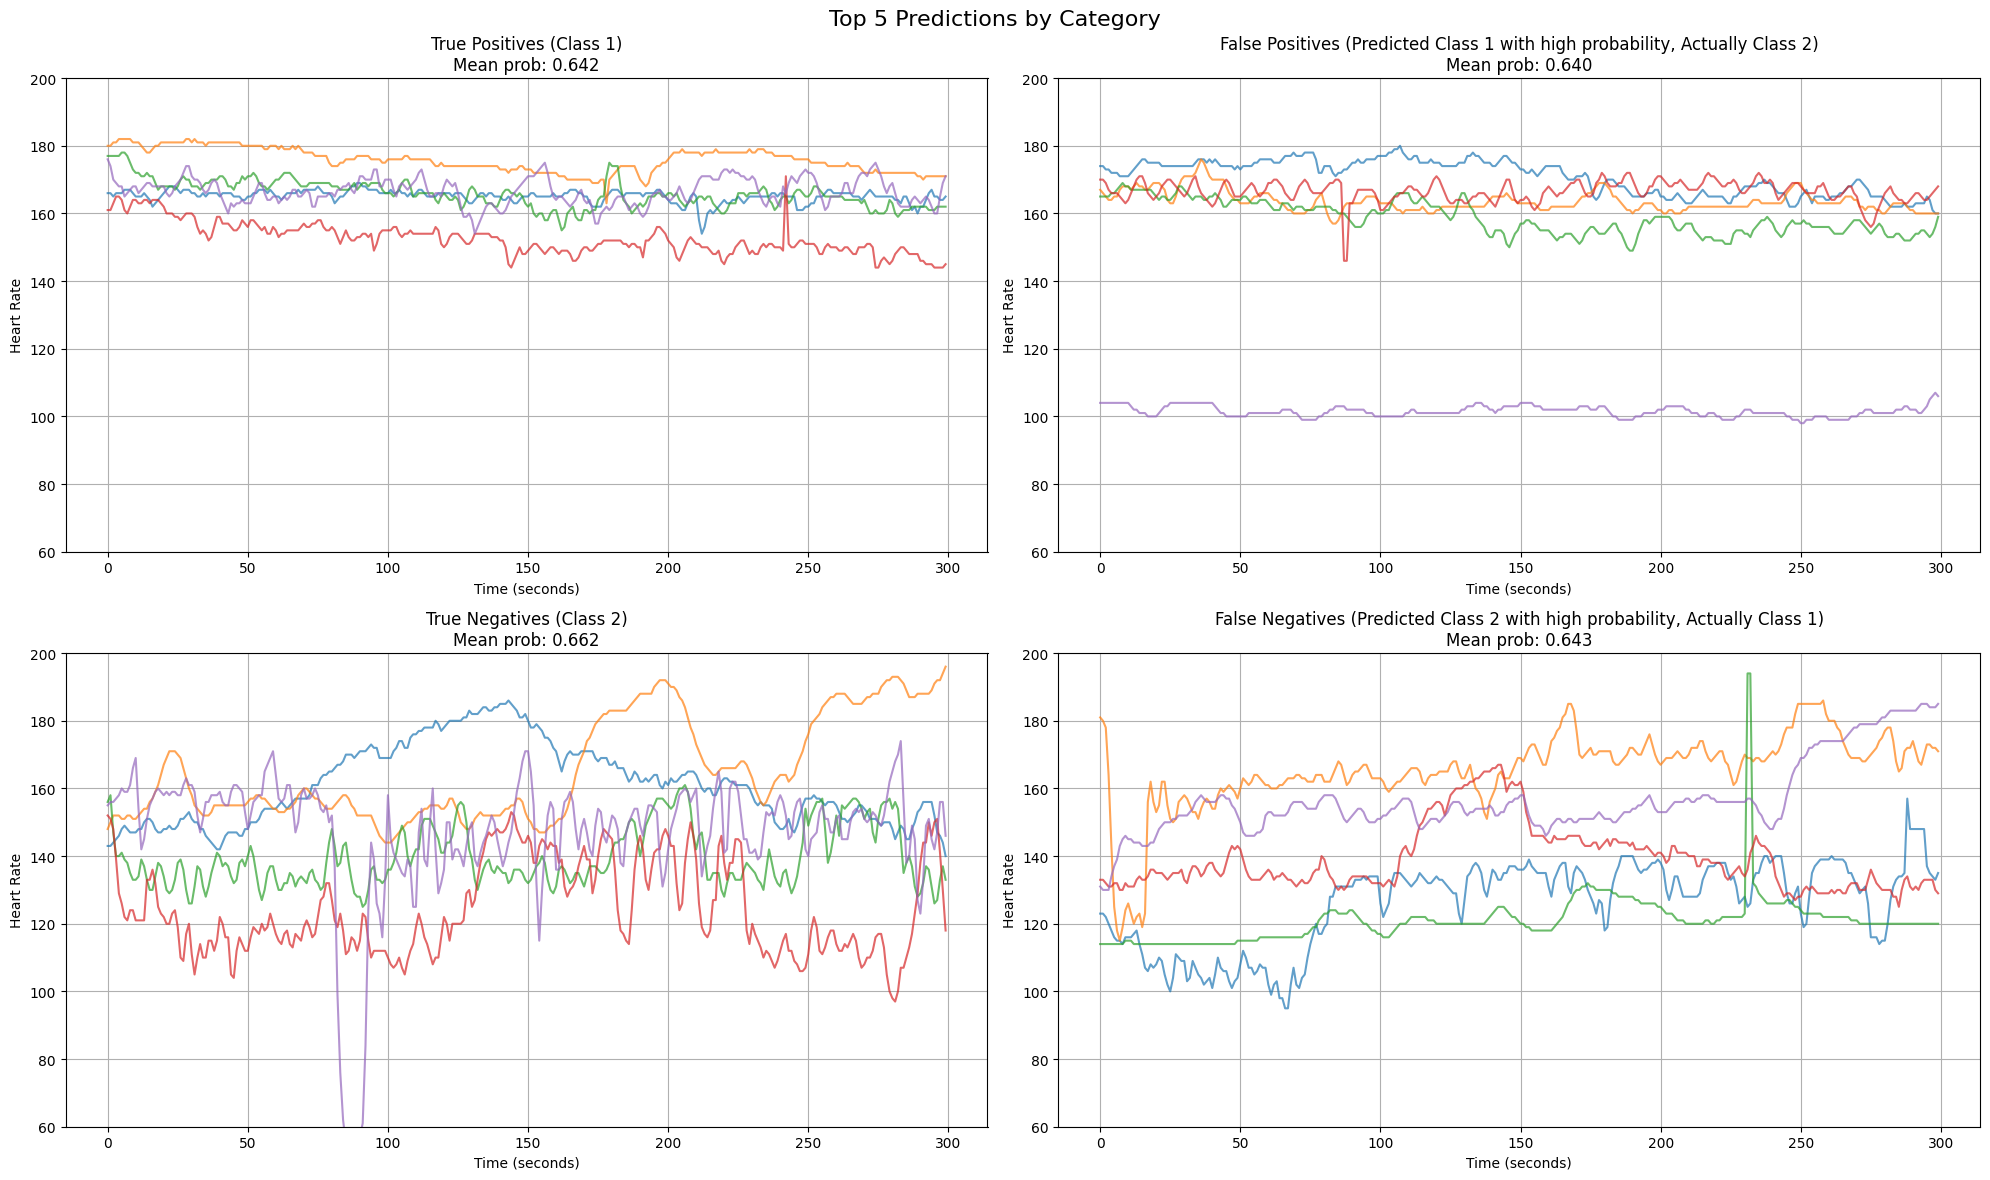

In [14]:
_, y_prob_test = eval_clip3d(model, evalinputs_test, return_probs=True)
_, y_prob_train = eval_clip3d(model, evalinputs_train, return_probs=True)
y_prob_test = pd.DataFrame(y_prob_test.cpu().numpy())
y_prob_train = pd.DataFrame(y_prob_train.cpu().numpy())

y_true_test = df_test[['true1','true2']]
y_true_train = df_train[['true1','true2']]

y_prob_test_recal = recalibrate_probabilities(y_true_test, y_prob_test, method='platt')
y_prob_train_recal = recalibrate_probabilities(y_true_train, y_prob_train, method='platt')

df_train_cali = diag_cali_plot(y_true_train, y_prob_train)
df_test_cali = diag_cali_plot(y_true_test, y_prob_test )
# df_train_cali = diag_cali_plot(y_true_train, y_prob_train_recal, n_bins=8)
# df_test_cali = diag_cali_plot(y_true_test, y_prob_test_recal, n_bins=8)
ts_train_idx = diag_plot_top_k_predictions(y_true_train, y_prob_train, df_train, K=5)
ts_test_idx = diag_plot_top_k_predictions(y_true_test, y_prob_test, df_test, K=5)

ts_train_idx = diag_plot_top_k_predictions(y_true_train, y_prob_train, df_train, K=50, plot=False)
ts_test_idx = diag_plot_top_k_predictions(y_true_test, y_prob_test, df_test, K=50, plot=False)
combined_idx = np.concatenate([ts_train_idx['true_pos_idx'], ts_train_idx['true_neg_idx']]).tolist()
df_train_shapelet = df_train.loc[combined_idx, :]
combined_idx = np.concatenate([ts_test_idx['true_pos_idx'], ts_test_idx['true_neg_idx']]).tolist()
df_test_shapelet = df_test.loc[combined_idx, :]

# df_train_shapelet.to_csv('./results/train_shapelet.csv')
# df_test_shapelet.to_csv('./results/test_shapelet.csv')